In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

## Basic usage

pyHalo generates populations of dark matter halos for lensing simualtions with lenstronomy (although future integration with other software is possible). The basic involves two steps: 
1) generating a realization, or a population of halos
2) using the lensing_quantities method to translate the realization into keyword arguments recognized by lenstronomy

To generate realizations with pyHalo you have to supply a number of keyword arguments to specify mass definitions, lens/source redshift, etc. This is made somewhat easier through the preset models, as demonstrated below. 

Additional detail about each preset model can be found in the associated example notebooks. The preset model functions also serve to demonstrate how to create customized dark matter halo realizations. 

realization contains 16594 halos.


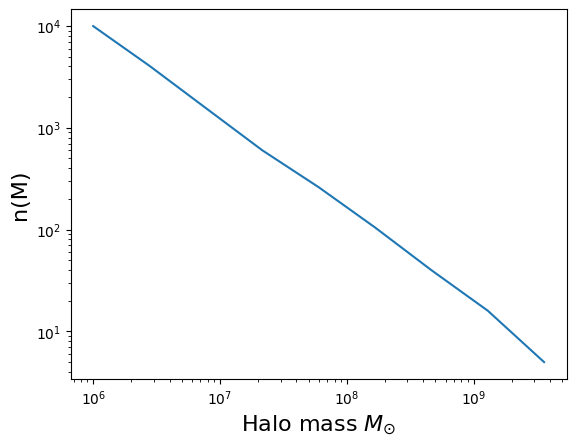

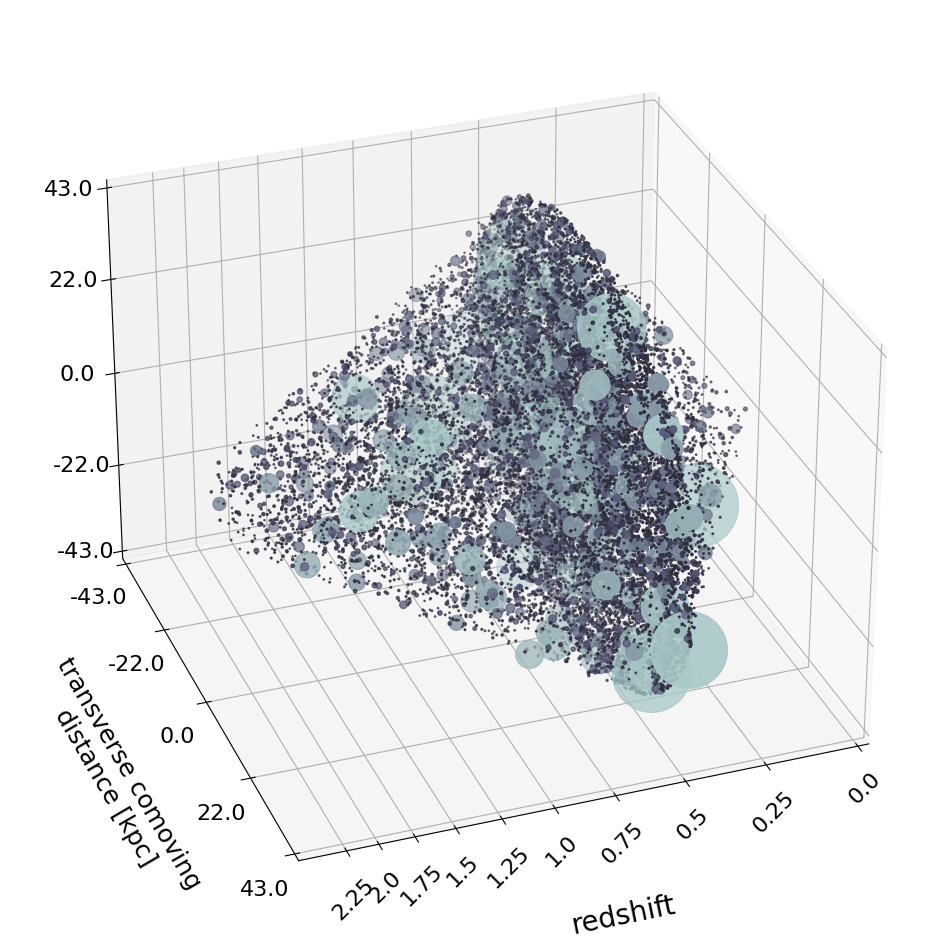

In [3]:
from pyHalo.PresetModels.cdm import CDM

zlens, zsource = 0.5, 2.5
realizationCDM = CDM(zlens, zsource, cone_opening_angle_arcsec=10)
print('realization contains '+str(len(realizationCDM.halos))+' halos.')
cdm_halo_masses = [halo.mass for halo in realizationCDM.halos]
N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))

fig = plt.figure(1)
ax = plt.subplot(111)
ax.loglog(m[0:-1], N)
ax.set_xlabel('Halo mass '+r'$M_{\odot}$', fontsize=16)
ax.set_ylabel('n(M)', fontsize=16)

fig = plt.figure(2)
fig.set_size_inches(14,12)
ax = plt.subplot(111, projection='3d')
realizationCDM.plot(ax)

### Geometry settings

You can change the geometry of the rendering volume by specifying the appropriate keyword argument

realization contains 32218 halos.


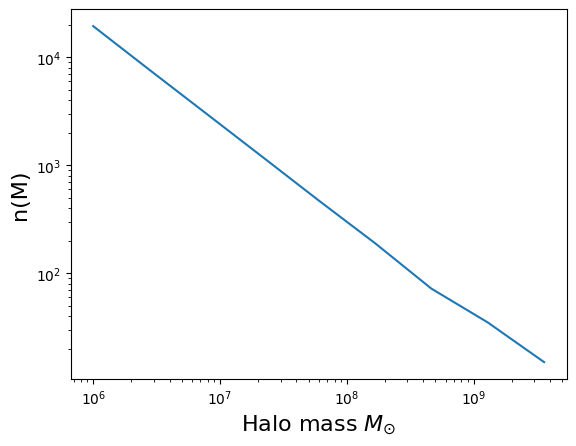

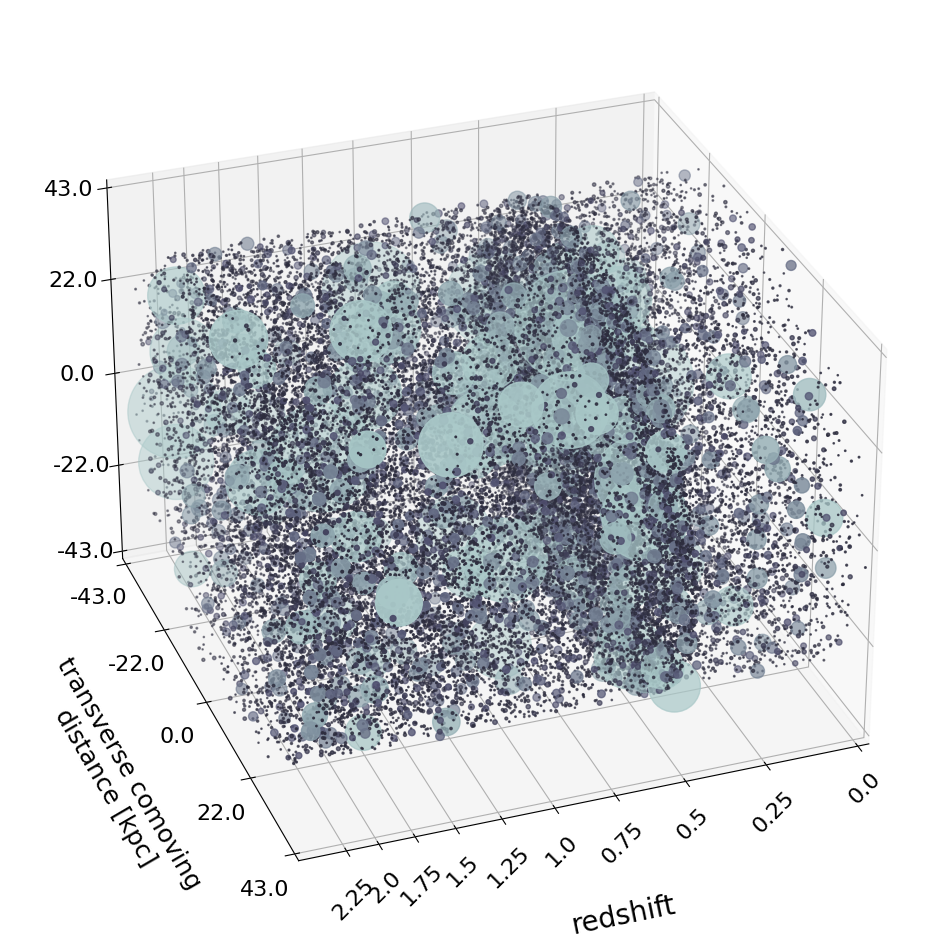

In [7]:
zlens, zsource = 0.5, 2.5
realizationCDM = CDM(zlens, zsource, cone_opening_angle_arcsec=10, geometry_type='CYLINDER')
print('realization contains '+str(len(realizationCDM.halos))+' halos.')
cdm_halo_masses = [halo.mass for halo in realizationCDM.halos]
N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))

fig = plt.figure(1)
ax = plt.subplot(111)
ax.loglog(m[0:-1], N)
ax.set_xlabel('Halo mass '+r'$M_{\odot}$', fontsize=16)
ax.set_ylabel('n(M)', fontsize=16)

fig = plt.figure(2)
fig.set_size_inches(14,12)
ax = plt.subplot(111, projection='3d')
realizationCDM.plot(ax)

## pyhalo is designed to be used with the software lenstronomy (https://github.com/sibirrer/lenstronomy)
In one step, you can go from a pyhalo realization to an instance of LensModel

In [9]:
lens_model_list, lens_redshift_array, kwargs_halos, _ = realizationCDM.lensing_quantities()
# you can ignore the last argument for almost all use cases
from lenstronomy.LensModel.lens_model import LensModel
# You should use the same astropy class created in pyhalo to do lensing computations. The current default cosmology is Planck 2019
astropy_instance = realizationCDM.astropy_instance
lens_model_halos_only = LensModel(lens_model_list, 
                                  zlens, 
                                  zsource, 
                                  lens_redshift_array, 
                                  cosmo=astropy_instance, 
                                  multi_plane=True)

We can look at the projected mass of the lens model with line of sight and subhalos only. The code automatically generates negative convergence sheets that subtract the mean mass rendered in halos, which is why some areas will appear underdense (blue) relative to the mean dark matter density, while other areas (halos) are overdense.

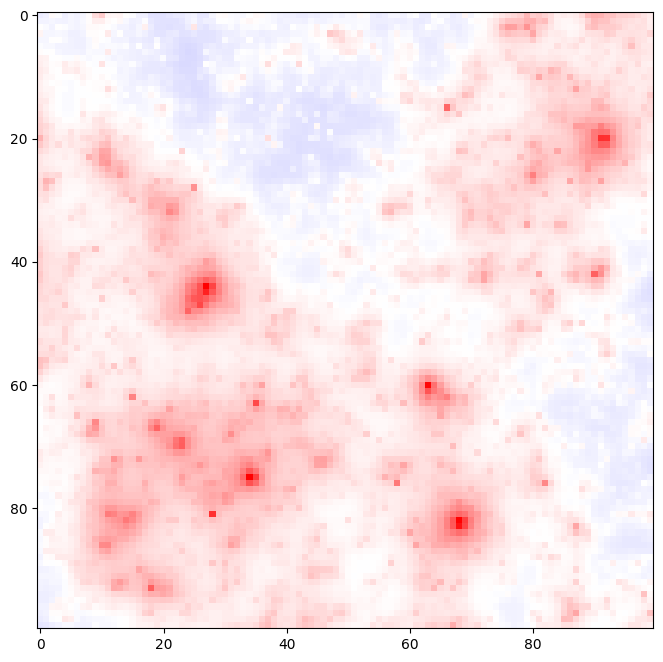

In [10]:
npix = 100 
_x = _y = np.linspace(-1.2, 1.2, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape
kappa_subs = lens_model_halos_only.kappa(xx.ravel(), yy.ravel(), kwargs_halos).reshape(shape0)

fig = plt.figure(1)
fig.set_size_inches(8,8)
plt.imshow(kappa_subs, vmin=-0.1, vmax=0.1, cmap='bwr')

Things look more interesting if you include a macromodel to compute the full convergence field, and then subtract off the mass profile of the main deflector at the end...

average convergence:  0.0015889395561773864


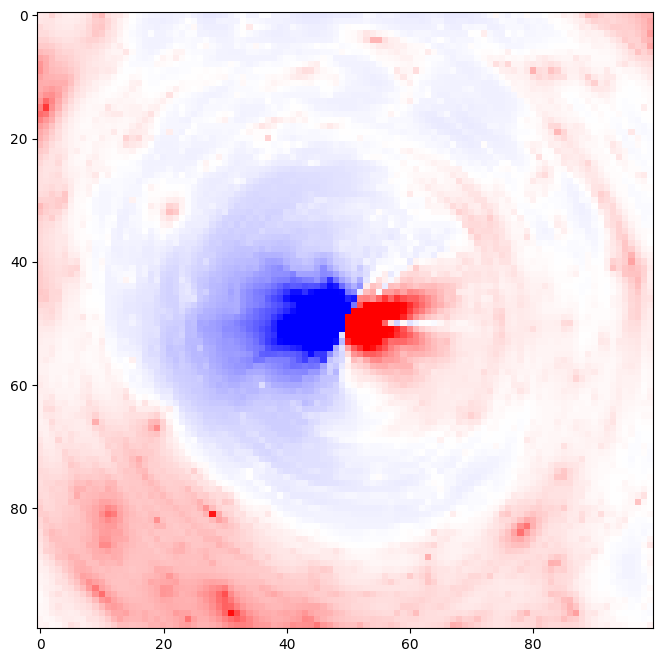

In [11]:
# power law plus shear macromodel
kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': 0., 'e1': 0.2, 'e2': -0.1, 'gamma': 2.},
                    {'gamma1': -0.04, 'gamma2': 0.09}]

lens_model_list_macro = ['EPL', 'SHEAR']
lens_model_list_full = lens_model_list_macro + lens_model_list
lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
kwargs_lens_full = kwargs_macromodel + kwargs_halos

lens_model_full = LensModel(lens_model_list_full, zlens, zsource, lens_redshift_list_full, cosmo=astropy_instance, multi_plane=True)
lens_model_macro = LensModel(lens_model_list_macro)

kappa_full = lens_model_full.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full).reshape(shape0)
kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel).reshape(shape0)

fig = plt.figure(1)
fig.set_size_inches(8,8)
kappa_nonlinear = kappa_full - kappa_macro
plt.imshow(kappa_nonlinear, vmin=-0.1, vmax=0.1, cmap='bwr')

print('average convergence: ', np.mean(kappa_nonlinear))


### Subtraction of negative mass sheets

pyHalo automatically subtracts negative sheets of convergence at each lens plane along the line of sight to correct for the mass you add in halos (hence why you see some blue in the figure above). The amount of convergence subtacted is automatically determined based on the parameters that specify the line of sight halo mass function; the intention is to add substructure without changing the overall normalization of the lensing convergence profile of the lens model. You can turn this feature off as follows: 


average convergence:  0.04039999152726425


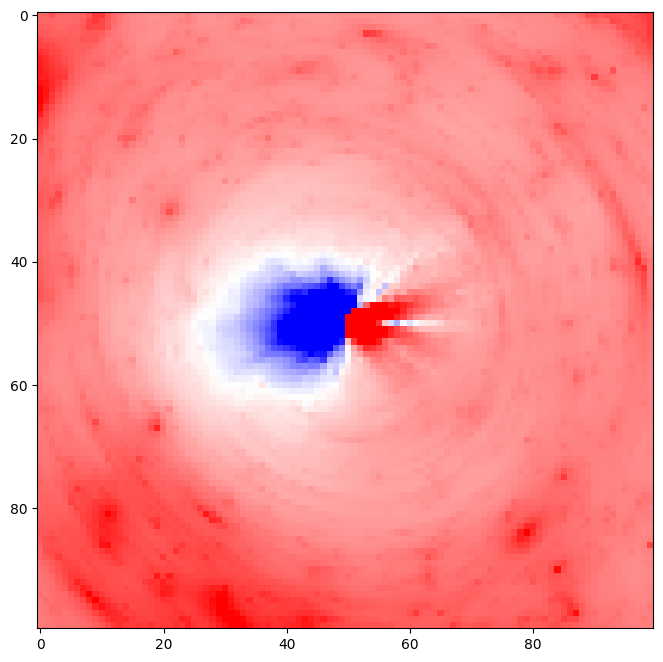

In [12]:
lens_model_list_nosheets, lens_redshift_array_nosheets, kwargs_halos_nosheets, _ = realizationCDM.lensing_quantities(add_mass_sheet_correction=False)

lens_model_list_full_nosheets = lens_model_list_macro + lens_model_list_nosheets
lens_redshift_list_full_nosheets = [zlens, zlens] + list(lens_redshift_array_nosheets)
kwargs_lens_full_nosheets = kwargs_macromodel + kwargs_halos_nosheets

lens_model_full_nosheets = LensModel(lens_model_list_full_nosheets, zlens, zsource, lens_redshift_list_full_nosheets, 
                                     cosmo=astropy_instance, multi_plane=True)

kappa_full_nosheets = lens_model_full_nosheets.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full_nosheets).reshape(shape0)

fig = plt.figure(1)
fig.set_size_inches(8,8)
kappa_nonlinear = kappa_full_nosheets - kappa_macro
plt.imshow(kappa_nonlinear, vmin=-0.1, vmax=0.1, cmap='bwr')

print('average convergence: ', np.mean(kappa_nonlinear))


### Subhalos only and line-of-sight only

You can generate only subhalos or only line-of-sight halos by setting the normalization to zero for either population

number of subhalos:  7734
number of field halos:  0


(array([   0.,    0.,    0.,    0.,    0., 7734.,    0.,    0.,    0.,
           0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

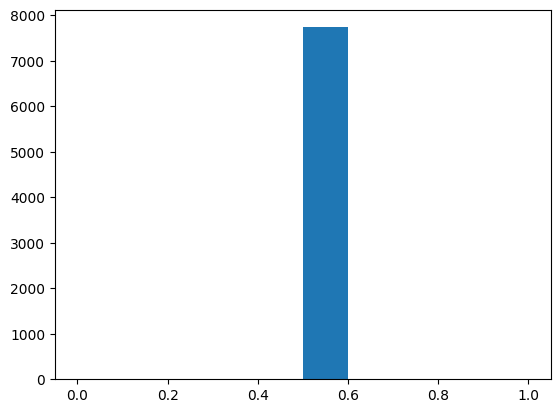

In [13]:
realizationCDM_subhalos = CDM(zlens, zsource, cone_opening_angle_arcsec=10, LOS_normalization=0.0)
nsubs = 0
nfield = 0
redshifts = []
for halo in realizationCDM_subhalos.halos:
    if halo.is_subhalo:
        nsubs += 1
    else:
        nfield += 1 
    redshifts.append(halo.z)
    
print('number of subhalos: ', nsubs)
print('number of field halos: ', nfield)

plt.hist(redshifts)

number of subhalos:  0
number of field halos:  8805


(array([ 395., 2334., 2334., 1488.,  940.,  578.,  342.,  227.,  114.,
          53.]),
 array([0.01 , 0.257, 0.504, 0.751, 0.998, 1.245, 1.492, 1.739, 1.986,
        2.233, 2.48 ]),
 <BarContainer object of 10 artists>)

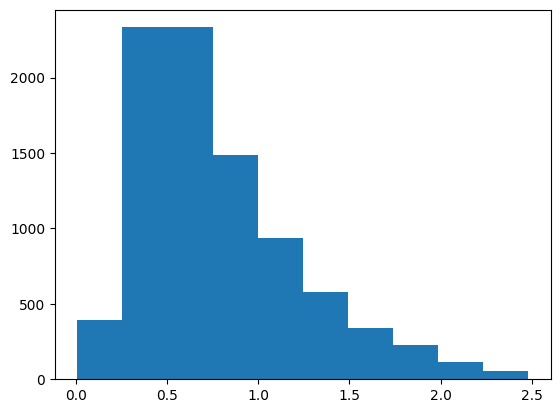

In [14]:
realizationCDM_fieldhalos = CDM(zlens, zsource, cone_opening_angle_arcsec=10, sigma_sub=0.0)
nsubs = 0
nfield = 0
redshifts = []
for halo in realizationCDM_fieldhalos.halos:
    if halo.is_subhalo:
        nsubs += 1
    else:
        nfield += 1 
    redshifts.append(halo.z)
    
print('number of subhalos: ', nsubs)
print('number of field halos: ', nfield)

plt.hist(redshifts)